In [ ]:
"""
To make sure the fusion decomposition works
up to the part where we would stitch the sublimbs together into one limb


"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [81]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu
import neuron_utils as nru

#importing at the bottom so don't get any conflicts
import itertools
from tqdm_utils import tqdm

#for meshparty preprocessing
import meshparty_skeletonize as m_sk
import general_utils as gu
import compartment_utils as cu
from meshparty import trimesh_io
from copy import deepcopy


from neuron_utils import *


# Loading the Neuron

In [3]:
import trimesh_utils as tu
curent_neuron = tu.load_mesh_no_processing("/notebooks/test_neurons/Segmentation_2/meshparty/864691135382617330_double_soma_large_axon.off")
segment_id = 864691135382617330
description = "double_soma_large_axon"

In [4]:
# import neuron_visualizations as nviz
# nviz.plot_objects(main_mesh=curent_neuron)

# Setting the Arguments that would be present inside a preprocessing function call

In [5]:
#predefined arguments for the Neuron constructor

decomposition_type="meshafterparty"
mesh_correspondence="meshparty" #meshafterparty_adaptive
distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
meshparty_adaptive_correspondence_after_creation=False
suppress_preprocessing_print=True
computed_attribute_dict=None
somas = None
branch_skeleton_data=None
combine_close_skeleton_nodes = True
combine_close_skeleton_nodes_threshold=700
ignore_warnings=True
suppress_output=False
calculate_spines=True
widths_to_calculate=["no_spine_median_mesh_center",
                "no_spine_mean_mesh_center"]
fill_hole_size=2000

In [6]:
#arguments for the preprocess neuron
mesh = curent_neuron
segment_id=segment_id
description=description

sig_th_initial_split=15 #for significant splitting meshes in the intial mesh split
limb_threshold = 2000 #the mesh faces threshold for a mesh to be qualified as a limb (otherwise too small)
filter_end_node_length=4001 #used in cleaning the skeleton during skeletonizations
return_no_somas = False

decomposition_type=decomposition_type
mesh_correspondence=mesh_correspondence
distance_by_mesh_center=distance_by_mesh_center
meshparty_segment_size =meshparty_segment_size
meshparty_n_surface_downsampling = meshparty_n_surface_downsampling
somas=somas
branch_skeleton_data=branch_skeleton_data
combine_close_skeleton_nodes = combine_close_skeleton_nodes
combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold

# Setting up the metadata

In [7]:
whole_processing_tiempo = time.time()


"""
Purpose: To process the mesh into a format that can be loaded into the neuron class
and used for higher order processing (how to visualize is included)

"""
if description is None:
    description = "no_description"
if segment_id is None:
    #pick a random segment id
    segment_id = np.random.randint(100000000)
    print(f"picking a random 7 digit segment id: {segment_id}")
    description += "_random_id"


if mesh is None:
    if current_mesh_file is None:
        raise Exception("No mesh or mesh_file file were given")
    else:
        current_neuron = trimesh.load_mesh(current_mesh_file)
else:
    current_neuron = mesh

# ************************ Phase A: Soma and Limb Identification ********************************

In [8]:
# --- 1) Doing the soma detection
if somas is None:
    soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)
else:
    soma_mesh_list,run_time,total_soma_list_sdf = somas

# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
    if return_no_somas:
        return_value= soma_mesh_list_centers
    raise Exception("Processing of No Somas is not yet implemented yet")
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 5273 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/864691135382617330/neuron_864691135382617330.off -o /notebooks/Platinum_Decomp_Fusion/864691135382617330/neuron_864691135382617330_decimated.off -s /notebooks/Platinum_Decomp_Fusion/864691135382617330/decimation_meshlab_25346210.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(190811, 3), faces.shape=(378905, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(190811, 3), faces.shape=(378905, 3))>
pre_largest_mesh_path = /notebooks/Platinum_Decomp_Fusion/864691135382617330/neuron_864691135382617330_decimated_largest_piece.off
xvfb-run -n 6432 -s "-screen 0 800x600x24" meshlabserver $@  -i /noteb

mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(93568, 3), faces.shape=(185548, 3))>, <trimesh.Trimesh(vertices.shape=(45531, 3), faces.shape=(90282, 3))>, <trimesh.Trimesh(vertices.shape=(20424, 3), faces.shape=(40376, 3))>, <trimesh.Trimesh(vertices.shape=(14722, 3), faces.shape=(29215, 3))>, <trimesh.Trimesh(vertices.shape=(7153, 3), faces.shape=(14176, 3))>, <trimesh.Trimesh(vertices.shape=(4474, 3), faces.shape=(8911, 3))>]
There were 6 pieces found after size threshold
mesh pieces in subtact soma AFTER the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(93568, 3), faces.shape=(185548, 3))>, <trimesh.Trimesh(vertices.shape=(45531, 3), faces.shape=(90282, 3))>, <trimesh.Trimesh(vertices.shape=(20424, 3), faces.shape=(40376, 3))>, <trimesh.Trimesh(vertices.shape=(14722, 3), faces.shape=(29215, 3))>, <trimesh.Trimesh(vertices.shape=(7153, 3), faces.shape=(14176, 3))>, <trimesh.Trimesh(vertices.shape=(4474, 3), faces.shape

In [9]:
#--- 2) getting the soma submeshes that are connected to each soma and identifiying those that aren't (and eliminating any mesh pieces inside the soma)

main_mesh_total = current_neuron


#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list,
                                        split_meshes)

# filtering away any of the inside floating pieces: 
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """

    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)                                                      


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]


#     print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
#     print(f"# of inside pieces = {len(inside_pieces)}")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")






# total split meshes = 108
There were 107 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0, 1]}


In [10]:
tu = reload(tu)
#--- 3)  Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

#     sk.graph_skeleton_and_mesh(other_meshes=[soma_meshes])

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


"""

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print(f"\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    current_time = time.time()
    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)
    print(f"Total time for Subtract Soam = {time.time() - current_time}")
    current_time = time.time()

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)

    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    print(f"Total time for Original_mesh_faces_map for mesh_pieces without soma= {time.time() - current_time}")
    current_time = time.time()
    soma_meshes = current_mesh.submesh([soma_faces],append=True,repair=False)

    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True,repair=False)

    print(f"Total time for Original_mesh_faces_map for somas= {time.time() - current_time}")
    current_time = time.time()

    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)

    print(f"Total time for sig_non_soma_pieces= {time.time() - current_time}")
    current_time = time.time()

    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces

    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    #take the top largest ones depending how many were originally in the soma list
    seperate_soma_meshes = seperate_soma_meshes[:len(soma_mesh_list)]
    soma_face_components = soma_face_components[:len(soma_mesh_list)]

    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes

    print(f"Total time for split= {time.time() - current_time}")
    current_time = time.time()



    soma_to_piece_connectivity = dict()
    soma_to_piece_touching_vertices = dict()
    soma_to_piece_touching_vertices_idx = dict()
    limb_root_nodes = dict()
    
    m_vert_graph = tu.mesh_vertex_graph(current_mesh)
    
    for i,curr_soma in enumerate(seperate_soma_meshes):
        (connected_mesh_pieces,
         connected_mesh_pieces_vertices,
         connected_mesh_pieces_vertices_idx) = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True,
                        return_vertices_idx=True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces

        soma_to_piece_touching_vertices[i] = dict()
        for piece_index,piece_idx in enumerate(connected_mesh_pieces):
            limb_root_nodes[piece_idx] = connected_mesh_pieces_vertices[piece_index][0]
            
            """ Old way of finding vertex connected components on a mesh without trimesh function
            #find the number of touching groups and save those 
            soma_touching_graph = m_vert_graph.subgraph(connected_mesh_pieces_vertices_idx[piece_index])
            soma_con_comp = [current_mesh.vertices[np.array(list(k)).astype("int")] for k in list(nx.connected_components(soma_touching_graph))]
            soma_to_piece_touching_vertices[i][piece_idx] = soma_con_comp
            """
            
            soma_to_piece_touching_vertices[i][piece_idx] = tu.split_vertex_list_into_connected_components(
                                                vertex_indices_list=connected_mesh_pieces_vertices_idx[piece_index],
                                                mesh=current_mesh, 
                                                vertex_graph=m_vert_graph, 
                                                return_coordinates=True
                                               )
            
            
            
            

#         border_debug = False
#         if border_debug:
#             print(f"soma_to_piece_connectivity = {soma_to_piece_connectivity}")
#             print(f"soma_to_piece_touching_vertices = {soma_to_piece_touching_vertices}")


    print(f"Total time for mesh_pieces_connectivity= {time.time() - current_time}")

    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")



# Lets have an alert if there was more than one soma disconnected meshes
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

current_mesh_data = soma_touching_mesh_data
soma_containing_idx = 0

#doing inversion of the connectivity and touching vertices
piece_to_soma_touching_vertices = gu.flip_key_orders_for_dict(soma_to_piece_touching_vertices)


# ****Soma Touching mesh Data has the branches and the connectivity (So this is where you end up skipping if you don't have somas)***



----Working on soma-containing mesh piece 0----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(185730, 3), faces.shape=(370654, 3))>, <trimesh.Trimesh(vertices.shape=(128995, 3), faces.shape=(257202, 3))>, <trimesh.Trimesh(vertices.shape=(125943, 3), faces.shape=(251486, 3))>, <trimesh.Trimesh(vertices.shape=(82227, 3), faces.shape=(163975, 3))>, <trimesh.Trimesh(vertices.shape=(61258, 3), faces.shape=(122260, 3))>, <trimesh.Trimesh(vertices.shape=(46188, 3), faces.shape=(92114, 3))>, <trimesh.Trimesh(vertices.shape=(34195, 3), faces.shape=(68245, 3))>, <trimesh.Trimesh(vertices.shape=(29600, 3), faces.shape=(59059, 3))>, <trimesh.Trimesh(vertices.shape=(16660, 3), faces.shape=(33269, 3))>, <trimesh.Trimesh(vertices.shape=(5880, 3), faces.shape=(11727, 3))>, <trimesh.Trimesh(vertices.shape=(4432, 3), faces.shape=(8797, 3))>, <trimesh.Trimesh(vertices.shape=(3264, 3), faces.shape=(6519, 3))>]
There were 12 pi

/meshAfterParty/trimesh_utils.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


Total time for mesh_pieces_connectivity= 24.88273525238037
# of insignificant_limbs = 0 with trimesh : []


# Process that will start for each limb

In [11]:
import preprocessing_vp2 as pre
from copy import deepcopy


In [ ]:
proper_limb_mesh_correspondence_MAP = dict()
proper_limb_mesh_correspondence_MP = dict()
limb_to_endpoints_must_keep_list = dict()
limb_to_soma_touching_vertices_list = dict()

#The containers that will hold the final data for the preprocessed neuron
limb_correspondence=dict()
limb_concept_networks=dict()
limb_labels=dict()

In [90]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
m_sk = reload(m_sk)


#For controlling which pieces are MAP
width_threshold = 450
size_threshold = 1000

verbose = True

proper_time = time.time()
print_fusion_steps=True

#parameter for CGAL skeletonization
use_surface_after_CGAL=False
surface_reconstruction_size = 500

#parameters for the stitching:

move_MAP_stitch_to_end_or_branch = True
distance_to_move_point_threshold=500

run_concept_network_checks = True


for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    
#     if curr_limb_idx != 11:
#         continue
    
    curr_limb_time = time.time()
    print(f"\n\n----- Working on Proper Limb #{curr_limb_idx} ---------")
    
    #will store a list of all the endpoints tha tmust be kept:
    limb_to_endpoints_must_keep_list[curr_limb_idx] = []
    limb_to_soma_touching_vertices_list[curr_limb_idx] = []
    
    
    
    
    fusion_time = time.time()
    # Doing the first pass of surface skeletonization
    total_border_vertices = dict()
    for l_idx,s_dict in piece_to_soma_touching_vertices.items():
        local_b_verts = []
        for sm_idx,sm_bord_verts in s_dict.items():
            local_b_verts.append(np.vstack(sm_bord_verts))
        total_border_vertices[l_idx] = np.vstack(local_b_verts)

    #will eventually get the current root from soma_to_piece_touching_vertices[i]
    root_curr = total_border_vertices[curr_limb_idx][0]
    if print_fusion_steps:
        print(f"Time for preparing soma vertices and root: {time.time() - fusion_time }")
        fusion_time = time.time()
    
    sk_meshparty_obj = m_sk.skeletonize_mesh_largest_component(limb_mesh_mparty,
                                                            root=root_curr,
                                                              filter_mesh=False)

    if print_fusion_steps:
        print(f"Time for 1st pass MP skeletonization: {time.time() - fusion_time }")
        fusion_time = time.time()
        
    (segment_branches, #skeleton branches
    divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
    segment_widths_median) = m_sk.skeleton_obj_to_branches(sk_meshparty_obj,
                                                          mesh = limb_mesh_mparty,
                                                          meshparty_segment_size=meshparty_segment_size)
    
    
    if print_fusion_steps:
        print(f"Decomposing first pass: {time.time() - fusion_time }")
        fusion_time = time.time()
    
    
    


    #gettin the branches that should be passed through MAP skeletonization
    pieces_above_threshold = np.where(segment_widths_median>width_threshold)[0]

    #getting the correspondnece info for those MAP qualifying
    width_large = segment_widths_median[pieces_above_threshold]
    sk_large = [segment_branches[k] for k in pieces_above_threshold]
    mesh_large_idx = [divided_submeshes_idx[k] for k in pieces_above_threshold]
    
    

    mesh_pieces_for_MAP = []

    if len(mesh_large_idx) > 0: #will only continue processing if found MAP candidates
        
        print(f"Found len(mesh_large_idx) MAP candidates: {[len(k) for k in mesh_large_idx]}")
        
        #finds the connectivity edges of all the MAP candidates
        mesh_large_connectivity = tu.mesh_list_connectivity(meshes = mesh_large_idx,
                                main_mesh = limb_mesh_mparty,
                                print_flag = False)
        if print_fusion_steps:
            print(f"mesh_large_connectivity: {time.time() - fusion_time }")
            fusion_time = time.time()
        """
        --------------- Grouping MAP candidates ----------------
        Purpose: Will see what mesh pieces should be grouped together
        to pass through CGAL skeletonization


        Pseudocode: 
        1) build a networkx graph with all nodes for mesh_large_idx indexes
        2) Add the edges
        3) Find the connected components
        4) Find sizes of connected components
        5) For all those connected components that are of a large enough size, 
        add the mesh branches and skeletons to the final list


        """
        G = nx.Graph()
        G.add_nodes_from(np.arange(len(mesh_large_idx)))
        G.add_edges_from(mesh_large_connectivity)
        conn_comp = list(nx.connected_components(G))

        filtered_pieces = []

        sk_large_size_filt = []
        mesh_large_idx_size_filt = []
        width_large_size_filt = []

        for cc in conn_comp:
            total_cc_size = np.sum([len(mesh_large_idx[k]) for k in cc])
            if total_cc_size>size_threshold:
                #print(f"cc ({cc}) passed the size threshold because size was {total_cc_size}")
                filtered_pieces.append(pieces_above_threshold[list(cc)])
                
        if print_fusion_steps:
            print(f"Finding MAP candidates connected components: {time.time() - fusion_time }")
            fusion_time = time.time()

        #filtered_pieces: will have the indexes of all the branch candidates that should  be 
        #grouped together and passed through MAP skeletonization

        if len(filtered_pieces) > 0:
            print(f"len(filtered_pieces) = {len(filtered_pieces)}")
            #all the pieces that will require MAP mesh correspondence and skeletonization
            #(already organized into their components)
            mesh_pieces_for_MAP = [limb_mesh_mparty.submesh([np.concatenate(divided_submeshes_idx[k])],append=True,repair=False) for k in filtered_pieces]
            mesh_pieces_for_MAP_face_idx = [np.concatenate(divided_submeshes_idx[k]) for k in filtered_pieces]
            
            pieces_idx_MP = np.setdiff1d(np.arange(len(divided_submeshes_idx)),np.concatenate(filtered_pieces))

            """
            Old Way: Finding connectivity of pieces through
            mesh_idx_MP = [divided_submeshes_idx[k] for k in pieces_idx_MP]

            mesh_large_connectivity_MP = tu.mesh_list_connectivity(meshes = mesh_idx_MP,
                                    main_mesh = limb_mesh_mparty,
                                    print_flag = False)

            New Way: going to use skeleton connectivity to determine
            connectivity of pieces

            Pseudocode: 
            1)

            """

            skeleton_MP = [segment_branches[k] for k in pieces_idx_MP]
            skeleton_connectivity_MP = sk.skeleton_list_connectivity(
                                            skeletons=skeleton_MP
                                            )
            if print_fusion_steps:
                print(f"skeleton_connectivity_MP : {time.time() - fusion_time }")
                fusion_time = time.time()

            G = nx.Graph()
            G.add_nodes_from(np.arange(len(skeleton_MP)))
            G.add_edges_from(skeleton_connectivity_MP)
            sublimbs_MP = list(nx.connected_components(G))
            sublimbs_MP_orig_idx = [pieces_idx_MP[list(k)] for k in sublimbs_MP]


            #concatenate into sublimbs the skeletons and meshes
            sublimb_mesh_idx_branches_MP = [divided_submeshes_idx[k] for k in sublimbs_MP_orig_idx]
            sublimb_mesh_branches_MP = [[limb_mesh_mparty.submesh([ki],append=True,repair=False)
                                        for ki in k] for k in sublimb_mesh_idx_branches_MP]
            sublimb_meshes_MP = [limb_mesh_mparty.submesh([np.concatenate(k)],append=True,repair=False)
                                                         for k in sublimb_mesh_idx_branches_MP]
            sublimb_meshes_MP_face_idx = [np.concatenate(k)
                                                         for k in sublimb_mesh_idx_branches_MP]
            sublimb_skeleton_branches = [segment_branches[k] for k in sublimbs_MP_orig_idx]
            widths_MP = [segment_widths_median[k] for k in sublimbs_MP_orig_idx]
            
            if print_fusion_steps:
                print(f"Grouping MP Sublimbs by Graph: {time.time() - fusion_time }")
                fusion_time = time.time()

    # else: #if no pieces were determine to need MAP processing
    #     print("No MAP processing needed: just returning the Meshparty skeletonization and mesh correspondence")
    #     raise Exception("Returning MP correspondence")


    # nviz.plot_objects(main_mesh=tu.combine_meshes([limb_mesh_mparty,current_neuron["S0"].mesh]),
    #                   main_mesh_color="green",
    #     skeletons=sk_large_size_filt,
    #      meshes=[limb_mesh_mparty.submesh([k],append=True) for k in mesh_large_idx_size_filt],
    #       meshes_colors="red")
    
    
    
    
    
    
    
    
    
    
    #if no sublimbs need to be decomposed with MAP then just reassign all of the previous MP processing to the sublimb_MPs
    if len(mesh_pieces_for_MAP) == 0:
        sublimb_meshes_MP = [limb_mesh_mparty] #trimesh pieces that have already been passed through MP skeletonization (may not need)
        # -- the decomposition information ---
        sublimb_mesh_branches_MP = [divided_submeshes] #the mesh branches for all the disconnected sublimbs
        sublimb_mesh_idx_branches_MP = [divided_submeshes_idx] #The mesh branches idx that have already passed through MP skeletonization
        sublimb_skeleton_branches = [segment_branches]#the skeleton bnraches for all the sublimbs
        widths_MP = [segment_widths_median] #the mesh branches widths for all the disconnected groups

        MAP_flag = False
    else:
        MAP_flag = True

    

    mesh_pieces_for_MAP #trimesh pieces that should go through CGAL skeletonization
    sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)

    # -- the decomposition information ---
    sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
    sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
    sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
    widths_MP #the mesh branches widths for all the disconnected groups
    
    if print_fusion_steps:
        print(f"Divinding into MP and MAP pieces: {time.time() - fusion_time }")
        fusion_time = time.time()

    
    
    # ------------------- At this point have the correct division between MAP and MP ------------------------
    
    # -------------- Doing the MAP decomposition ------------------ #
    global_start_time = time.time()
    endpoints_must_keep = dict()

    perform_cleaning_checks = False

    limb_correspondence_MAP = dict()
    
    for sublimb_idx,(mesh,mesh_idx) in enumerate(zip(mesh_pieces_for_MAP,mesh_pieces_for_MAP_face_idx)):
        print(f"--- Working on MAP piece {sublimb_idx}---")
        mesh_start_time = time.time()
        curr_soma_to_piece_touching_vertices = pre.filter_soma_touching_vertices_dict_by_mesh(
        mesh = mesh,
        curr_piece_to_soma_touching_vertices = piece_to_soma_touching_vertices[curr_limb_idx]
        )
        
        if print_fusion_steps:
            print(f"MAP Filtering Soma Pieces: {time.time() - fusion_time }")
            fusion_time = time.time()

        # ---- 0) Generating the Clean skeletons  -------------------------------------------#
        if not curr_soma_to_piece_touching_vertices is None:
            total_border_vertices = dict([(k,np.vstack(v)) for k,v in curr_soma_to_piece_touching_vertices.items()])

        cleaned_branch,curr_limb_endpoints_must_keep = sk.skeletonize_and_clean_connected_branch_CGAL(
            mesh=mesh,
            curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
            total_border_vertices=total_border_vertices,
            filter_end_node_length=filter_end_node_length,
            perform_cleaning_checks=perform_cleaning_checks,
            combine_close_skeleton_nodes = combine_close_skeleton_nodes,
            combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold,
        use_surface_after_CGAL=use_surface_after_CGAL,
        surface_reconstruction_size=surface_reconstruction_size)
        
        if not curr_limb_endpoints_must_keep is None:
            limb_to_endpoints_must_keep_list[curr_limb_idx].append(curr_limb_endpoints_must_keep)
            limb_to_soma_touching_vertices_list[curr_limb_idx].append(curr_soma_to_piece_touching_vertices)
        else:
            print("Inside MAP decomposition and curr_limb_endpoints_must_keep was None")

        if len(cleaned_branch) == 0:
            raise Exception(f"Found a zero length skeleton for limb {z} of trmesh {branch}")
            
        if print_fusion_steps:
            print(f"skeletonize_and_clean_connected_branch_CGAL: {time.time() - fusion_time }")
            fusion_time = time.time()

        # ---- 1) Generating Initial Mesh Correspondence -------------------------------------------#
        start_time = time.time()

        print(f"Working on limb correspondence for #{sublimb_idx} MAP piece")
        local_correspondence = pre.mesh_correspondence_first_pass(mesh=mesh,
                                                             skeleton=cleaned_branch,
                                                             distance_by_mesh_center=distance_by_mesh_center)


        print(f"Total time for decomposition = {time.time() - start_time}")
        if print_fusion_steps:
            print(f"mesh_correspondence_first_pass: {time.time() - fusion_time }")
            fusion_time = time.time()


        #------------- 2) Doing Some checks on the initial corespondence -------- #

        perform_cleaning_checks = True       
        if perform_cleaning_checks:
            pre.check_skeletonization_and_decomp(skeleton=cleaned_branch,
                                            local_correspondence=local_correspondence)

        # -------3) Finishing off the face correspondence so get 1-to-1 correspondence of mesh face to skeletal piece
        local_correspondence_revised = pre.correspondence_1_to_1(mesh=mesh,
                                        local_correspondence=local_correspondence,
                                        curr_limb_endpoints_must_keep=curr_limb_endpoints_must_keep,
                                        curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices)
        
        # -------3b) Fixing the mesh indices to correspond to the larger mesh as a whole
        for k,v in local_correspondence_revised.items():
            local_correspondence_revised[k]["branch_face_idx"] = mesh_idx[local_correspondence_revised[k]["branch_face_idx"]]
        
        print(f"Total time for MAP sublimb #{sublimb_idx} mesh processing = {time.time() - mesh_start_time}")
        
        if print_fusion_steps:
            print(f"correspondence_1_to_1: {time.time() - fusion_time }")
            fusion_time = time.time()

        limb_correspondence_MAP[sublimb_idx] = local_correspondence_revised

    print(f"Total time for MAP sublimb processing {time.time() - global_start_time}")

    

    
    
    # ----------------- Part B: Doing the MP Decomposition ---------------------- #
    
    
    
    
    sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)
    # -- the decomposition information ---
    sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
    sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
    sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
    widths_MP #the mesh branches widths for all the disconnected groups

    limb_correspondence_MP = dict()

    print("***************Arrived at MESH PIECES FOR MAP AND mp***************")
    for sublimb_idx,mesh in enumerate(sublimb_meshes_MP):
        print(f"---- Working on MP Decomposition #{sublimb_idx} ----")
        mesh_start_time = time.time()

        if len(sublimb_meshes_MP) == 1 and MAP_flag == False:
            print("Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece ")
            curr_soma_to_piece_touching_vertices = piece_to_soma_touching_vertices[curr_limb_idx]
        else:
            curr_soma_to_piece_touching_vertices = pre.filter_soma_touching_vertices_dict_by_mesh(
                                                mesh = mesh,
                                                curr_piece_to_soma_touching_vertices = piece_to_soma_touching_vertices[curr_limb_idx]
                                                )
            
        if print_fusion_steps:
            print(f"MP filtering soma verts: {time.time() - fusion_time }")
            fusion_time = time.time()

        #creating all of the sublimb groups
        segment_branches = sublimb_skeleton_branches[sublimb_idx]
        whole_sk_MP = sk.stack_skeletons(segment_branches)
        branch = mesh
        divided_submeshes = sublimb_mesh_branches_MP[sublimb_idx]
        divided_submeshes_idx = sublimb_mesh_idx_branches_MP[sublimb_idx]
        segment_widths_median = widths_MP[sublimb_idx]

        if curr_soma_to_piece_touching_vertices is None:
            print(f"Do Not Need to Fix MP Decomposition {sublimb_idx} so just continuing")

        else:
            print(f"Fixing Possible Soma Extension Branch for Sublimb {sublimb_idx}")

            #If there is some soma touching then need to see if have to fix soma extending pieces
            return_info = sk.create_soma_extending_branches(current_skeleton=whole_sk_MP,
                                      skeleton_mesh=branch,
                                      soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
                                      return_endpoints_must_keep=True,
                                         return_created_branch_info=True)
            new_sk,endpts,new_branch_info = return_info

            if print_fusion_steps:
                print(f"MP (because soma touching verts) create_soma_extending_branches: {time.time() - fusion_time }")
                fusion_time = time.time()

            no_soma_extension_add = True
            
            if not endpts is None:
                limb_to_endpoints_must_keep_list[curr_limb_idx].append(endpts)
                limb_to_soma_touching_vertices_list[curr_limb_idx].append(curr_soma_to_piece_touching_vertices)
            
            for sm_idx in new_branch_info.keys():        
                for b_vert_idx,br_info in enumerate(new_branch_info[sm_idx]):
                    if br_info is None:
                        continue
                    no_soma_extension_add=False


                    #1) Get the newly added branch (and the original vertex which is the first row)
                    br_new,sm_bord_verts = br_info["new_branch"],br_info["border_verts"] #this will hold the new branch and the border vertices corresponding to it

                    curr_soma_to_piece_touching_vertices_MP = {sm_idx:[sm_bord_verts]}
                    endpoints_must_keep_MP = {sm_idx:[br_new[0][1]]}
                    

                    orig_vertex = br_new[0][0]

                    #2) Find the branches that have that coordinate (could be multiple)
                    match_sk_branches = sk.find_branch_skeleton_with_specific_coordinate(segment_branches,
                        current_coordinate=orig_vertex)

                    #2b) If multiple branches: Pick a winning branch that has the most of the
                    #    soma touching vertices
                    if len(match_sk_branches) > 1:
                        bord_verts_tree = KDTree(sm_bord_verts.reshape(-1,3))
                        winning_branch = match_sk_branches[0]
                        dist,_ = bord_verts_tree.query(divided_submeshes[winning_branch].vertices)
                        winning_branch_n_bord_verts = np.sum(dist == 0)

                        for i in range(1,len(match_sk_branches)):
                            curr_branch = match_sk_branches[i]
                            dist,_ = bord_verts_tree.query(divided_submeshes[winning_branch].vertices)
                            n_bord_verts = np.sum(dist == 0)
                            if n_bord_verts>winning_branch_n_bord_verts:
                                winning_branch_n_bord_verts = n_bord_verts
                                winning_branch = curr_branch
                    elif len(match_sk_branches) == 1:
                        winning_branch = match_sk_branches[0]
                    else:
                        raise Exception("No matching branches found for soma extending point")

                    if verbose:
                        print(f"Winning Branch = {winning_branch}")

                    #3) Find the mesh and skeleton of the winning branch
                    winning_branch_mesh = divided_submeshes[winning_branch]
                    winning_branch_mesh_idx = divided_submeshes_idx[winning_branch]
                    winning_branch_sk = segment_branches[winning_branch]

                    #4) Add newly created branch to skeleton and divide the skeleton into branches (could make 2 or 3)
                    extended_skeleton_to_soma = sk.stack_skeletons([winning_branch_sk,br_new])
                    soma_extending_branches = sk.decompose_skeleton_to_branches(extended_skeleton_to_soma)

                    #5) Run Adaptive mesh correspondnece using branches and mesh
                    local_correspondnece_MP = pre.mesh_correspondence_first_pass(mesh=winning_branch_mesh,
                                                  skeleton=extended_skeleton_to_soma)

                    local_correspondence_revised = pre.correspondence_1_to_1(mesh=winning_branch_mesh,
                                                                local_correspondence=local_correspondnece_MP,
                                                                curr_limb_endpoints_must_keep=endpoints_must_keep_MP,
                                                                curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices_MP)

                    # All the things that should be revised:
                #     segment_branches, #skeleton branches
                #     divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
                #     segment_widths_median


                    new_submeshes = [k["branch_mesh"] for k in local_correspondence_revised.values()]
                    new_submeshes_idx = [winning_branch_mesh_idx[k["branch_face_idx"]] for k in local_correspondence_revised.values()]
                    new_skeletal_branches = [k["branch_skeleton"] for k in local_correspondence_revised.values()]

                    #calculate the new width
                    ray_inter = tu.ray_pyembree.RayMeshIntersector(limb_mesh_mparty)
                    new_widths = []
                    for new_s_idx in new_submeshes_idx:
                        curr_ray_distance = tu.ray_trace_distance(mesh=limb_mesh_mparty, 
                                            face_inds=new_s_idx,
                                           ray_inter=ray_inter)
                        new_widths.append(np.median(curr_ray_distance[curr_ray_distance!=0]))


                    #6) Remove the original branch and mesh correspondence and replace with the multiples
                #     new_segment_branches = deepcopy(segment_branches)
                #     new_divided_submeshes = deepcopy(divided_submeshes)
                #     new_divided_submeshes_idx = deepcopy(divided_submeshes_idx)
                #     new_segment_widths_median = deepcopy(segment_widths_median)

                    segment_branches = np.delete(segment_branches,winning_branch)
                    segment_branches = np.append(segment_branches,new_skeletal_branches,axis=0)

                    divided_submeshes = np.delete(divided_submeshes,winning_branch)
                    divided_submeshes = np.append(divided_submeshes,new_submeshes,axis=0)

                    divided_submeshes_idx = np.delete(divided_submeshes_idx,winning_branch)
                    divided_submeshes_idx = np.append(divided_submeshes_idx,new_submeshes_idx,axis=0)

                    segment_widths_median = np.delete(segment_widths_median,winning_branch)
                    segment_widths_median = np.append(segment_widths_median,new_widths,axis=0)




            if no_soma_extension_add:
                print("No soma extending branch was added for this sublimb even though it had a soma border (means they already existed)")

            if print_fusion_steps:
                print(f"MP (because soma touching verts) soma extension add: {time.time() - fusion_time }")
                fusion_time = time.time()
            
        #building the limb correspondence
        limb_correspondence_MP[sublimb_idx] = dict()

        for zz,b_sk in enumerate(segment_branches):
            limb_correspondence_MP[sublimb_idx][zz] = dict(
                branch_skeleton = b_sk,
                width_from_skeleton = segment_widths_median[zz],
                branch_mesh = divided_submeshes[zz],
                branch_face_idx = divided_submeshes_idx[zz]
                )
            
            
            
        
        
    # ------------------------------------- Part C: Will make sure the correspondences can all be stitched together --------------- #

    # Only want to perform this step if both MP and MAP pieces
    if len(limb_correspondence_MAP)>0 and len(limb_correspondence_MP)>0:


        # ---- Doing the mesh connectivity ---------#
        sublimb_meshes_MP = []
        sublimb_skeletons_MP = []

        for sublimb_key,sublimb_v in limb_correspondence_MP.items():
            sublimb_meshes_MP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
            sublimb_skeletons_MP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))

        sublimb_meshes_MAP = []
        sublimb_skeletons_MAP = []

        for sublimb_key,sublimb_v in limb_correspondence_MAP.items():
            sublimb_meshes_MAP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
            sublimb_skeletons_MAP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))



        mesh_conn,mesh_conn_vertex_groups = tu.mesh_list_connectivity(meshes = sublimb_meshes_MP + sublimb_meshes_MAP,
                                            main_mesh = limb_mesh_mparty,
                                            min_common_vertices=1,
                                            return_vertex_connection_groups=True,
                                            return_largest_vertex_connection_group=True,
                                            print_flag = False)

        #check that every MAP piece mapped to a MP piece
        mesh_conn_filt = []
        mesh_conn_vertex_groups_filt = []
        for j,(m1,m2) in enumerate(mesh_conn):
            if m1 < len(sublimb_meshes_MP) and m2 >=len(sublimb_meshes_MP):
                mesh_conn_filt.append([m1,m2])
                mesh_conn_vertex_groups_filt.append(mesh_conn_vertex_groups[j])
        mesh_conn_filt = np.array(mesh_conn_filt)

        mesh_conn = mesh_conn_filt
        mesh_conn_vertex_groups = mesh_conn_vertex_groups_filt

        #check that the mapping should create only one connected component
        G = nx.from_edgelist(mesh_conn)

        if len(G) != len(sublimb_meshes_MP) + len(sublimb_meshes_MAP):
            raise Exception("Number of nodes in mesh connectivity graph is not equal to number of  MAP and MP sublimbs")

        connect_comp = list(nx.connected_components(G))
        if len(connect_comp)>1:
            raise Exception(f"Mesh connectivity was not one component, instead it was ({len(connect_comp)}): {connect_comp} ")
            
            
            

        #adjust the connection indices for MP and MAP indices
        mesh_conn_adjusted = np.vstack([mesh_conn[:,0],mesh_conn[:,1]-len(sublimb_meshes_MP)]).T






        """
        Pseudocode:
        For each connection edge:
            For each vertex connection group:
                1) Get the endpoint vertices of the MP skeleton
                2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
                3) Find the closest skeletal point on MAP pairing (MAP stitch) 
                4) Find the branches that have that MAP stitch point:
                5A) If the number of branches corresponding to stitch point is multipled
                    --> then we are stitching at a branching oint
                    i) Just add the skeletal segment from MP_stitch to MAP stitch to the MP skeletal segment
                    ii) 

        """


        for (MP_idx,MAP_idx),v_g in zip(mesh_conn_adjusted,mesh_conn_vertex_groups):
            print(f"\n---- Working on {(MP_idx,MAP_idx)} connection-----")

            """
            This old way of getting the endpoints was not good because could possibly just need
            a stitching done between original branch junction

            skeleton_MP_graph = sk.convert_skeleton_to_graph(curr_skeleton_MP)
            endpoint_nodes = xu.get_nodes_of_degree_k(skeleton_MP_graph,1)
            endpoint_nodes_coordinates = xu.get_node_attributes(skeleton_MP_graph,node_list=endpoint_nodes)
            """


            #getting the skeletons that should be stitched
            curr_skeleton_MP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MP[MP_idx].values()])
            curr_skeleton_MAP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MAP[MAP_idx].values()])

            #1) Get the endpoint vertices of the MP skeleton (needs to be inside loop because limb correspondence will change)
            curr_MP_branch_skeletons = [k["branch_skeleton"] for k in limb_correspondence_MP[MP_idx].values()]
            endpoint_nodes_coordinates = np.array([sk.find_branch_endpoints(k) for k in curr_MP_branch_skeletons])
            endpoint_nodes_coordinates = np.unique(endpoint_nodes_coordinates.reshape(-1,3),axis=0)

            #2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
            av_vert = np.mean(v_g,axis=0)
            winning_vertex = endpoint_nodes_coordinates[np.argmin(np.linalg.norm(endpoint_nodes_coordinates-av_vert,axis=1))]
            print(f"winning_vertex = {winning_vertex}")


            #2b) Find the branch points where the winning vertex is located
            MP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
                divded_skeleton=curr_MP_branch_skeletons,
                current_coordinate = winning_vertex
            )
            print(f"MP_branches_with_stitch_point = {MP_branches_with_stitch_point}")


            #3) Find the closest skeletal point on MAP pairing (MAP stitch)
            MAP_skeleton_coords = np.unique(curr_skeleton_MAP.reshape(-1,3),axis=0)
            MAP_stitch_point = MAP_skeleton_coords[np.argmin(np.linalg.norm(MAP_skeleton_coords-winning_vertex,axis=1))]


            #3b) Consider if the stitch point is close enough to end or branch node in skeleton:
            # and if so then reassign
            if move_MAP_stitch_to_end_or_branch:
                MAP_stitch_point_new,change_status = sk.move_point_to_nearest_branch_end_point_within_threshold(
                                                        graph=curr_skeleton_MAP,
                                                        coordinate=MAP_stitch_point,
                                                        distance_to_move_point_threshold = distance_to_move_point_threshold,
                                                        verbose=True

                                                        )
                MAP_stitch_point=MAP_stitch_point_new


            #4) Find the branches that have that MAP stitch point:
            curr_MAP_branch_skeletons = [k["branch_skeleton"] for k in limb_correspondence_MAP[MAP_idx].values()]

            MAP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
                divded_skeleton=curr_MAP_branch_skeletons,
                current_coordinate = MAP_stitch_point
            )


            MAP_stitch_point_on_end_or_branch = False
            if len(MAP_branches_with_stitch_point)>1:
                MAP_stitch_point_on_end_or_branch = True
            elif len(MAP_branches_with_stitch_point)==1:
                if len(nu.matching_rows(sk.find_branch_endpoints(curr_MAP_branch_skeletons[MAP_branches_with_stitch_point[0]]),
                                        MAP_stitch_point))>0:
                    MAP_stitch_point_on_end_or_branch=True
            else:
                raise Exception("No matching MAP values")


            print(f"MAP_branches_with_stitch_point = {MAP_branches_with_stitch_point}")
            print(f"MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")


            # ------------------------- This part does the stitching -------------------- #


            """
            Pseudocode:
            1) For all MP branches
                a) Get neighbor coordinates to MP stitch points
                b) Delete the MP Stitch points on each 
                c) Add skeleton segment from neighbor to MAP stitch point
            2) Get skeletons and meshes from MP and MAP pieces
            3) Run mesh correspondence to get new meshes and mesh_idx and widths
            4a) If MAP_stitch_point_on_end_or_branch is False
            - Delete the old MAP branch parts and replace with new MAP ones
            4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces
            5) Revise the meshes,  mesh_idx, and widths of the MP pieces


            """

            curr_MP_sk = []
            for b_idx in MP_branches_with_stitch_point:

                #a) Get neighbor coordinates to MP stitch points
                MP_stitch_branch_graph = sk.convert_skeleton_to_graph(curr_MP_branch_skeletons[b_idx])
                stitch_node = xu.get_nodes_with_attributes_dict(MP_stitch_branch_graph,dict(coordinates=winning_vertex))[0]
                stitch_neighbors = xu.get_neighbors(MP_stitch_branch_graph,stitch_node)

                if len(stitch_neighbors) != 1:
                    raise Exception("Not just one neighbor for stitch point of MP branch")
                keep_neighbor = stitch_neighbors[0]  
                keep_neighbor_coordinates = xu.get_node_attributes(MP_stitch_branch_graph,node_list=[keep_neighbor])[0]

                #b) Delete the MP Stitch points on each 
                MP_stitch_branch_graph.remove_node(stitch_node)

                #c) Add skeleton segment from neighbor to MAP stitch point
                new_node_name = np.max(MP_stitch_branch_graph.nodes())+1

                MP_stitch_branch_graph.add_nodes_from([(int(new_node_name),{"coordinates":MAP_stitch_point})])
                MP_stitch_branch_graph.add_weighted_edges_from([(keep_neighbor,new_node_name,np.linalg.norm(MAP_stitch_point - keep_neighbor_coordinates))])

                new_MP_skeleton = sk.convert_graph_to_skeleton(MP_stitch_branch_graph)
                
                #smooth over the new skeleton
                new_MP_skeleton_smooth = sk.resize_skeleton_branch(new_MP_skeleton,
                                                                  segment_width=meshparty_segment_size)
                
                curr_MP_sk.append(new_MP_skeleton_smooth)



            #2) Get skeletons and meshes from MP and MAP pieces
            curr_MAP_sk = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"] for k in MAP_branches_with_stitch_point]

            #2.1) Going to break up the MAP skeleton if need be
            """
            Pseudocode:
            a) check to see if it needs to be broken up
            If it does:
            b) Convert the skeleton into a graph
            c) Find the node of the MAP stitch point (where need to do the breaking)
            d) Find the degree one nodes
            e) For each degree one node:
            - Find shortest path from stitch node to end node
            - get a subgraph from that path
            - convert graph to a skeleton and save as new skeletons

            """
            #a) check to see if it needs to be broken up
            if not MAP_stitch_point_on_end_or_branch:
                if len(curr_MAP_sk) > 1:
                    raise Exception(f"There was more than one skeleton for MAP skeletons even though MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")

                curr_MAP_sk_new = []
                #b) Convert the skeleton into a graph
                curr_MAP_sk_graph = sk.convert_skeleton_to_graph(curr_MAP_sk[0])
                #c) Find the node of the MAP stitch point (where need to do the breaking)
                MP_stitch_node = xu.get_nodes_with_attributes_dict(curr_MAP_sk_graph,dict(coordinates=MAP_stitch_point))[0]
                #d) Find the degree one nodes
                curr_end_nodes_for_break = xu.get_nodes_of_degree_k(curr_MAP_sk_graph,1)

                #e) For each degree one node:
                for e_n in curr_end_nodes_for_break:
                    #- Find shortest path from stitch node to end node
                    stitch_to_end_path = nx.shortest_path(curr_MAP_sk_graph,MP_stitch_node,e_n)
                    #- get a subgraph from that path
                    stitch_to_end_path_graph = curr_MAP_sk_graph.subgraph(stitch_to_end_path)
                    #- convert graph to a skeleton and save as new skeletons
                    new_sk = sk.convert_graph_to_skeleton(stitch_to_end_path_graph)
                    curr_MAP_sk_new.append(new_sk)
                curr_MAP_sk = curr_MAP_sk_new

            curr_MAP_meshes_idx = [limb_correspondence_MAP[MAP_idx][k]["branch_face_idx"] for k in MAP_branches_with_stitch_point]

            curr_MP_sk
            curr_MP_meshes_idx = [limb_correspondence_MP[MP_idx][k]["branch_face_idx"] for k in MP_branches_with_stitch_point]

            stitching_mesh_idx = np.concatenate(curr_MAP_meshes_idx + curr_MP_meshes_idx)
            stitching_mesh = limb_mesh_mparty.submesh([stitching_mesh_idx],append=True,repair=True)
            stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk
            """

            ****** NEED TO GET THE RIGHT MESH TO RUN HE IDX ON SO GETS A GOOD MESH (CAN'T BE LIMB_MESH_MPARTY)
            BUT MUST BE THE ORIGINAL MAP MESH

            mesh_pieces_for_MAP
            sublimb_meshes_MP

            mesh_pieces_for_MAP_face_idx
            sublimb_meshes_MP_face_idx

            stitching_mesh = tu.combine_meshes(curr_MAP_meshes + curr_MP_meshes)
            stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk

            """



            #3) Run mesh correspondence to get new meshes and mesh_idx and widths
            local_correspondnece_stitch = pre.mesh_correspondence_first_pass(mesh=stitching_mesh,
                                          skeleton_branches=stitching_skeleton_branches)

            local_correspondence_stitch_revised = pre.correspondence_1_to_1(mesh=stitching_mesh,
                                                        local_correspondence=local_correspondnece_stitch,
                                                        curr_limb_endpoints_must_keep=None,
                                                        curr_soma_to_piece_touching_vertices=None)

            #Need to readjust the mesh correspondence idx
            for k,v in local_correspondence_stitch_revised.items():
                local_correspondence_stitch_revised[k]["branch_face_idx"] = stitching_mesh_idx[local_correspondence_stitch_revised[k]["branch_face_idx"]]

            #4a) If MAP_stitch_point_on_end_or_branch is False
            #- Delete the old MAP branch parts and replace with new MAP ones
            if not MAP_stitch_point_on_end_or_branch:
                print("Deleting branches from dictionary")
                del limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]]
                #adding the two new branches created from the stitching
                limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]] = local_correspondence_stitch_revised[0]
                limb_correspondence_MAP[MAP_idx][np.max(list(limb_correspondence_MAP[MAP_idx].keys()))+1] = local_correspondence_stitch_revised[1]

                #have to reorder the keys
                limb_correspondence_MAP[MAP_idx] = dict([(k,limb_correspondence_MAP[MAP_idx][k]) for k in np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))])

            else: #4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces if weren't broken up
                for j,curr_MAP_idx_fixed in enumerate(MAP_branches_with_stitch_point):
                    limb_correspondence_MAP[MAP_idx][curr_MAP_idx_fixed] = local_correspondence_stitch_revised[j]

            #5) Revise the meshes,  mesh_idx, and widths of the MP pieces
            for j,curr_MP_idx_fixed in enumerate(MP_branches_with_stitch_point):
                limb_correspondence_MP[MP_idx][curr_MP_idx_fixed] = local_correspondence_stitch_revised[j+len(curr_MAP_sk)]


            print(f" Finished with {(MP_idx,MAP_idx)} \n\n\n")


    else:
        print("There were not both MAP and MP pieces so skipping the stitch resolving phase")
    
    print(f"Time for decomp of Limb {curr_limb_idx} = {time.time() - curr_limb_time}")
    # ------------- Saving the MAP and MP Decompositions ---------------- #
    proper_limb_mesh_correspondence_MAP[curr_limb_idx] = limb_correspondence_MAP
    proper_limb_mesh_correspondence_MP[curr_limb_idx] = limb_correspondence_MP
    
    
    
    
    
    
    # ------------------ Part D: Compiling the MP and MAP together ---------------- #
    limb_correspondence_individual = dict()
    counter = 0

    for sublimb_idx,sublimb_branches in limb_correspondence_MAP.items():
        for branch_dict in sublimb_branches.values():
            limb_correspondence_individual[counter]= branch_dict
            counter += 1
    for sublimb_idx,sublimb_branches in limb_correspondence_MP.items():
        for branch_dict in sublimb_branches.values():
            limb_correspondence_individual[counter]= branch_dict
            counter += 1

    divided_skeletons = np.array([limb_correspondence_individual[k]["branch_skeleton"] for k in np.sort(list(limb_correspondence_individual.keys()))])
    
    # ------------------ Part E: Compiling the MP and MAP together ---------------- #
    
    
    """
    Concept Network Pseudocode:

    Step 0: Compile the Limb correspondence into final form

    Make sure these have the same list
    limb_to_soma_touching_vertices_list,limb_to_endpoints_must_keep_list

    For every dictionary in zip(limb_to_soma_touching_vertices_list[curr_limb_idx],
                            limb_to_endpoints_must_keep_list[curr_limb_idx]):

        #make sure the dicts have same keys
        For every key (represents the soma) in the dictionary:

            #make sure the lists have the same sizes
            For every item in the list (which would be a list of endpoints or list of groups of vertexes):
                #At this point have the soma, the endpoint and the touching vertices

                1) find the branch with the endoint that must keep
                    --> if multiple endpoints then error
                2) Call the branches_to_concept_network with the
                   a. divided skeletons
                   b. closest endpoint
                   c. endpoints of branch (from the branch found)
                   d. touching soma vertices

                3) Run the checks on the concept network

    """

    curr_touching_verts_list = limb_to_soma_touching_vertices_list[curr_limb_idx]
    curr_endpoints_must_keep = limb_to_endpoints_must_keep_list[curr_limb_idx]

    limb_to_soma_concept_networks = dict()

    if len(curr_touching_verts_list) != len(curr_endpoints_must_keep):
        raise Exception(f"curr_touching_verts_list ({curr_touching_verts_list}) not same size as curr_endpoints_must_keep ({len(curr_endpoints_must_keep)})")

    for touch_vert_dict,endpoints_keep_dict in zip(curr_touching_verts_list,curr_endpoints_must_keep):
        if not np.array_equal(list(touch_vert_dict.keys()),list(endpoints_keep_dict.keys())):
            raise Exception(f"touch_vert_dict keys ({touch_vert_dict.keys()}) don't match endpoints_keep_dict keys ({endpoints_keep_dict.keys()})")
        for soma_idx in touch_vert_dict.keys():
            soma_t_verts_list = touch_vert_dict[soma_idx]
            soma_endpt_list = endpoints_keep_dict[soma_idx]

            if soma_idx not in list(limb_to_soma_concept_networks.keys()):
                limb_to_soma_concept_networks[soma_idx] = []

            if len(soma_t_verts_list) != len(soma_endpt_list):
                raise Exception(f"soma_t_verts_list length ({len(soma_t_verts_list)}) not equal to soma_endpt_list length ({soma_endpt_list})")
            for t_verts,endpt in zip(soma_t_verts_list,soma_endpt_list):



                #1) find the branch with the endoint that must keep
                start_branch = sk.find_branch_skeleton_with_specific_coordinate(divded_skeleton=divided_skeletons,
                                                                current_coordinate=endpt)[0]
                print(f"Starting_branch = {start_branch}")
                print(f"Start endpt = {endpt}")
                start_branch_endpoints = sk.find_branch_endpoints(divided_skeletons[start_branch])
                print(f"Starting_branch endpoints = {start_branch_endpoints}")

                #2) Call the branches_to_concept_network with the
                curr_limb_concept_network = nru.branches_to_concept_network(curr_branch_skeletons=divided_skeletons,
                                                                      starting_coordinate=endpt,
                                                                      starting_edge=start_branch_endpoints,
                                                                      touching_soma_vertices=t_verts)
                print("Done generating concept network \n\n")


                run_checks = True
                check_print_flag = True

                if run_concept_network_checks:
                    #3) Run the checks on the concept network
                    #3.1: check to make sure the starting coordinate was recovered

                    recovered_touching_piece = xu.get_nodes_with_attributes_dict(curr_limb_concept_network,dict(starting_coordinate=endpt))

                    if check_print_flag:
                        print(f"recovered_touching_piece = {recovered_touching_piece}")
                    if recovered_touching_piece[0] != start_branch:
                        raise Exception(f"For limb {curr_limb_idx} and soma {soma_idx} the recovered_touching and original touching do not match\n"
                                       f"recovered_touching_piece = {recovered_touching_piece}, original_touching_pieces = {start_branch}")


                    #3.2: Check number of nodes match the number of divided skeletons
                    if len(curr_limb_concept_network.nodes()) != len(divided_skeletons):
                        raise Exception("The number of nodes in the concept graph and number of branches passed to it did not match\n"
                                      f"len(curr_limb_concept_network.nodes())={len(curr_limb_concept_network.nodes())}, len(curr_limb_divided_skeletons)= {len(divided_skeletons)}")

                    #3.3: Check that concept network is a connected component
                    if nx.number_connected_components(curr_limb_concept_network) > 1:
                        raise Exception("There was more than 1 connected components in the concept network")


                    #3.4 Make sure the oriiginal divided skeleton endpoints match the concept map endpoints
                    for j,un_resized_b in enumerate(divided_skeletons):
                        """
                        Pseudocode: 
                        1) get the endpoints of the current branch
                        2) get the endpoints in the concept map
                        3) compare
                        - if not equalt then break
                        """
                        #1) get the endpoints of the current branch
                        b_endpoints = neuron.Branch(un_resized_b).endpoints
                        #2) get the endpoints in the concept map
                        graph_endpoints = xu.get_node_attributes(curr_limb_concept_network,attribute_name="endpoints",node_list=[j])[0]
                        #print(f"original_branch_endpoints = {b_endpoints}, concept graph node endpoints = {graph_endpoints}")
                        if not xu.compare_endpoints(b_endpoints,graph_endpoints):
                            raise Exception(f"The node {j} in concept graph endpoints do not match the endpoints of the original branch\n"
                                           f"original_branch_endpoints = {b_endpoints}, concept graph node endpoints = {graph_endpoints}")

                limb_to_soma_concept_networks[soma_idx].append(curr_limb_concept_network)
    
    
    #Storing all of the data to be sent to 
    
    limb_correspondence[curr_limb_idx] = limb_correspondence_individual
    limb_concept_networks[curr_limb_idx] = limb_to_soma_concept_networks
    limb_labels[curr_limb_idx]= "Unlabeled"

preprocessed_data= dict(
    soma_meshes = current_mesh_data[0]["soma_meshes"],
    soma_to_piece_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"],
    soma_sdfs = total_soma_list_sdf,
    insignificant_limbs=insignificant_limbs,
    non_soma_touching_meshes=non_soma_touching_meshes,
    inside_pieces=inside_pieces,
    limb_correspondence=limb_correspondence,
    limb_concept_networks=limb_concept_networks,
    limb_labels=limb_labels,
    limb_meshes=current_mesh_data[0]["branch_meshes"],
    )

print(f"Total time for all limb decomps = {time.time() - proper_time}")

  0%|          | 0/1 [00:00<?, ?it/s]



----- Working on Proper Limb #11 ---------
Time for preparing soma vertices and root: 0.0003113746643066406
smooth_neighborhood = 1


100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Time for 1st pass MP skeletonization: 0.1267991065979004
branches_touching_root = [0]
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.15094542503356934
Found len(mesh_large_idx) MAP candidates: [6519]
mesh_large_connectivity: 0.00012135505676269531
Finding MAP candidates connected components: 8.869171142578125e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.004496335983276367
Grouping MP Sublimbs by Graph: 5.364418029785156e-05
Divinding into MP and MAP pieces: 2.384185791015625e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.002767324447631836
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=500
     Starting Screened Poisson
xvfb-run -n 9720 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_232214.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
U


Total Mesh subtraction time = 0.4497



No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.03287482261657715
The process was using a temp folder
    Total time for skeletonizing branch: 8.056792974472046
skipping soma 1 because closest skeleton node was already end node
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.2677876949310303
filter_end_node_length = 4001
Using Distance measure skeletal_distance
Going to ignore certain endnodes that are 5000 nm close to soma border vertices
Number of end_nodes BEFORE filtering = 4
Using an already specified end node: 89 with index 3checking was correct node end_nodes[index] = 89
May Eliminate end_node 3: 89 because path_len to soma border was 2046.3209016773098
single_node_to_eliminate = 3
all_single_nodes_to_eliminate = [3, 3]



********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 8.45424509048462
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 0.5364835262298584
mesh_correspondence_first_pass: 0.5365166664123535
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (85, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (85, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.08114741524773739
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 9.173044919967651
correspondence_1_to_1: 0.17949533462524414
Total time for MAP sublimb processing 9.17315125465393
***************Arrived at MESH PIECES FOR MAP AND mp***************
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb 11 = 9.456640005111694
Starting_branch = 0
Start endpt = [586684. 878212. 832844.]
Starting_branch endpoints = [[562014. 875362. 853596.]
 [586684. 878212. 832844.]]
Starting_edge inside branches_to_conept = [[562014. 875362. 853596.]
 [586684. 878212. 832844.]]
Done generating concept network 


recovered_touching_piece = [0]
Total time for all limb decomps = 9.471050262451172


# Sending the data to the Neuron Object

In [97]:
neuron = reload(neuron)
nru = reload(nru)

In [101]:
neuron_obj = neuron.Neuron(
                mesh=curent_neuron,
                 segment_id=segment_id,
                 description=description,
                 preprocessed_data=preprocessed_data,
#                  decomposition_type="meshafterparty",
#                  mesh_correspondence="meshparty", #meshafterparty_adaptive
#                  distance_by_mesh_center=True, #how the distance is calculated for mesh correspondence
#                  meshparty_segment_size = 0,
#                  meshparty_n_surface_downsampling = 0,
#                  meshparty_adaptive_correspondence_after_creation=False,
#                 suppress_preprocessing_print=True,
#                  computed_attribute_dict=None,
#                  somas = None,
#                  branch_skeleton_data=None,
#                  combine_close_skeleton_nodes = True,
#                 combine_close_skeleton_nodes_threshold=700,
    
    
                ignore_warnings=True,
                suppress_output=False,
                calculate_spines=False,
                 widths_to_calculate=[]#["no_spine_median_mesh_center",
#                                     "no_spine_mean_mesh_center"]
                )

Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 0.00011134147644042969
total_edges = [['S0', 'L0'], ['S0', 'L2'], ['S0', 'L3'], ['S0', 'L4'], ['S0', 'L7'], ['S0', 'L8'], ['S1', 'L1'], ['S1', 'L2'], ['S1', 'L5'], ['S1', 'L6'], ['S1', 'L9'], ['S1', 'L10'], ['S1', 'L11']]
--- 2) Finished creating neuron connectivity graph: 0.0003228187561035156
Having to generate soma_meshes_face_idx because none in preprocessed data
--- 3a) Finshed generating soma_meshes_face_idx: 0.7750566005706787
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 7257 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_201452.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_201452_poisson.off -s /notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_582139.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_201452.off
removed temporary output file: /not

In [102]:
nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [126]:
import spine_utils as spu
tu = reload(tu)
spu = reload(spu)
neuron_obj.calculate_spines()

query = median_mesh_center > 200 and n_faces_branch>100
smoothness_threshold = 0.08
The median_mesh_center was requested and HAS already been calculated


In [127]:
nviz.plot_spines(neuron_obj)


 Working on visualization type: mesh


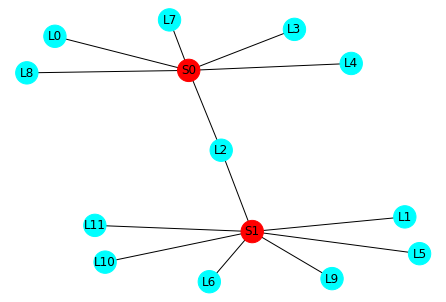

In [128]:
nviz.plot_soma_limb_concept_network(neuron_obj)

In [130]:
description

'double_soma_large_axon'

In [131]:
neuron_obj.save_compressed_neuron("/notebooks/test_neurons/Fusion_decomp/",
                                 export_mesh=True)

Saving Neuorn in suppress_output mode...please wait
Saved File at location: /notebooks/test_neurons/Fusion_decomp/864691135382617330_double_soma_large_axon
